# Tutorial on a toy example

We will design a graph with two communities influencing the behavior of a central node in a Graph Neural Network on a node prediction use case.

The tutorial is divided into two cases:

a) All the nodes in one of the communities have labels of almost 1 (0.9), and the nodes in the other community
have labels of almost 0 (0.1). The central node is assigned a label of 0.9, and we show how the community with the nodes labelled as 0.9 is the most relevant for the value of 0.9 in the central node, according to XP-GNN.

b) We complete the same use case as in a), but now "flipping" the labels. The community with low values of 0.9 in a) now has values of 0.1, and viceversa. In this case, we show how the other community is appointed as the most relevant one for
the Graph Neural Network explanation, according to XP-GNN.

# This notebook focuses on case A


# This experiment is a replica of the Experiment in Section 5.1 of "Community explanations in knowledge graphs with XP-GNN", by Andrés Martínez Mora, Dimitris Polychronopoulos, Michaël Ughetto, and Sebastian Nilsson

# Import libraries for analysis

In [1]:
import pandas as pd
import os,sys
import numpy as np
import networkx
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Linear
from sklearn.metrics import r2_score
from torch_geometric.data import Data
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathway_explanations.explainer import Explainer, set_seed

In [2]:
# Set random seed
seed = 0
set_seed(seed)

# Set up graph data

In [3]:
# Define device where to complete computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup edge index
edge_index = torch.tensor([[0,1],[1,0],[1,2],[2,1],[1,3],[3,1],[1,4],[4,1]],dtype=torch.long,
                              device=device)
edge_index = edge_index.T

# Set up community weights and community structure
communities = [[0],[2,3,4]]
community_names = ["blue","red"]

# Set node features as normally distributed
length = 16 # Feature size
features = torch.randn(int(torch.max(edge_index[0]).item())+1,
                       length, device=device)

node_names = ["{}".format(i) for i in range(features.shape[0])]

# Design training labels: CASE A
Y = torch.tensor([0.9,0.9,0.1,0.1,0.1],dtype=torch.float,
                              device=device)

# Define train and test mask
# Central node is in the test set
test_size = 0.2
train_mask = torch.rand(Y.shape, device=device)
train_mask[train_mask < test_size] = 0
train_mask[train_mask > test_size] = 1
train_mask = train_mask.bool()
train_mask[1] = False # Keep node of interest in testing set
test_mask = ~train_mask

# Plot graph

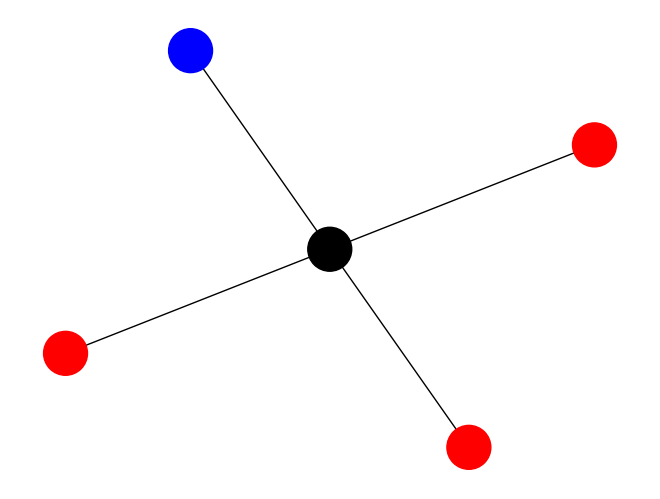

In [4]:
edges_nx = [tuple(edge_index[:,i].cpu().numpy()) for i in range(edge_index.shape[-1])]
G = networkx.Graph()
G.add_edges_from(edges_nx)
colors = ["blue","black","red","red","red"]

plt.figure()
networkx.draw(G,node_color=colors,node_size=1000,with_labels=False)
plt.show()

# Model for training artificial graph

In [5]:
class GCN_homo(torch.nn.Module): # Homogeneous GCN
    def __init__(self, node_features):
        super().__init__()
        
        # Load hyperparameters
        seed = 0
        hidden_channels = 8
        out_neurons = 1
        conv_layers = [16, 8, 8]
        fc_layers = [8, 8, 16]

        seed,out_neurons = int(seed),int(out_neurons)
        
        torch.manual_seed(seed)
        
        conv_list,fc_list = [],[]
        
        for enum_conv_layer,conv_layer in enumerate(conv_layers): # Setup convolutional backbone
            assert isinstance(conv_layer,int) or isinstance(conv_layer,float),"Size of convolutional layer is not numeric"
            conv_layer = abs(int(conv_layer))
            
            if enum_conv_layer == 0:
                conv = GCNConv(node_features,conv_layer)
            else:
                conv = GCNConv(conv_layers[enum_conv_layer - 1],conv_layer)
                
            conv_list.append(conv)
            conv_list.append(nn.ReLU())
            
        self.conv = nn.ModuleList(conv_list)
        
        for enum_fc_layer,fc_layer in enumerate(fc_layers): # Setup linear backbone
        
            assert isinstance(fc_layer,int) or isinstance(fc_layer,float),"Size of convolutional layer is not numeric"
        
            if enum_fc_layer == (len(fc_layers) - 1): # Last FC layer
                lin = Linear(fc_layers[enum_fc_layer],out_neurons)
                act = nn.Sigmoid()
            else:
                lin = Linear(fc_layers[enum_fc_layer],fc_layers[enum_fc_layer + 1])
                act = nn.ReLU()
            fc_list.append(lin)
            fc_list.append(act)
            
        self.fc = nn.ModuleList(fc_list[:(-1)])
        #self.fc = nn.ModuleList(fc_list)
        
        
    def forward(self,x,edge_index):
        
        for enum_c,c in enumerate(self.conv): # Convolutional backbone
            if enum_c % 2 == 0: # Even layer: convolution
                x = c(x, edge_index)
            else: # Odd layer: activation function
                x = c(x)
                
        for l in self.fc: # Fully-connected backbone
            x = l(x)
        
        return x

# Model training

In [6]:
# Call architecture
model = GCN_homo(features.shape[-1]).to(device)
print(model)

# Load optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in range(500):
    optimizer.zero_grad()
    H = model(features, 
              edge_index)
    
    # Use MSE as loss for weight prediction
    loss = F.mse_loss(H.flatten(), 
                      Y.flatten())
    loss.backward()
    optimizer.step()
    
    r2_val = r2_score(Y[test_mask].cpu().detach().numpy(),
                      H[test_mask].cpu().detach().numpy())
    
    print("Epoch:", epoch+1, "// Train loss:", round(loss.item(),4),"// Validation R2:", round(r2_val,4)) 
    
    val_old = r2_val    

GCN_homo(
  (conv): ModuleList(
    (0): GCNConv(16, 16)
    (1): ReLU()
    (2): GCNConv(16, 8)
    (3): ReLU()
    (4): GCNConv(8, 8)
    (5): ReLU()
  )
  (fc): ModuleList(
    (0): Linear(8, 8, bias=True)
    (1): ReLU()
    (2): Linear(8, 16, bias=True)
    (3): ReLU()
    (4): Linear(16, 1, bias=True)
  )
)
Epoch: 1 // Train loss: 0.3659 // Validation R2: -1.8164
Epoch: 2 // Train loss: 0.3361 // Validation R2: -1.5934
Epoch: 3 // Train loss: 0.3055 // Validation R2: -1.3649
Epoch: 4 // Train loss: 0.2801 // Validation R2: -1.1732
Epoch: 5 // Train loss: 0.2626 // Validation R2: -1.0499
Epoch: 6 // Train loss: 0.2477 // Validation R2: -0.9345
Epoch: 7 // Train loss: 0.2349 // Validation R2: -0.8388
Epoch: 8 // Train loss: 0.2236 // Validation R2: -0.7501
Epoch: 9 // Train loss: 0.2138 // Validation R2: -0.6647
Epoch: 10 // Train loss: 0.2066 // Validation R2: -0.6055
Epoch: 11 // Train loss: 0.2005 // Validation R2: -0.5454
Epoch: 12 // Train loss: 0.1946 // Validation R2: -0.486

Epoch: 157 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 158 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 159 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 160 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 161 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 162 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 163 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 164 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 165 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 166 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 167 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 168 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 169 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 170 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 171 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 172 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 173 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 174 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 175 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 176 /

Epoch: 323 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 324 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 325 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 326 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 327 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 328 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 329 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 330 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 331 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 332 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 333 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 334 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 335 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 336 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 337 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 338 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 339 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 340 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 341 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 342 /

Epoch: 480 // Train loss: 0.0001 // Validation R2: 0.9992
Epoch: 481 // Train loss: 0.0002 // Validation R2: 0.9986
Epoch: 482 // Train loss: 0.0002 // Validation R2: 0.9981
Epoch: 483 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 484 // Train loss: 0.0002 // Validation R2: 0.9983
Epoch: 485 // Train loss: 0.0 // Validation R2: 0.9999
Epoch: 486 // Train loss: 0.0001 // Validation R2: 0.9992
Epoch: 487 // Train loss: 0.0001 // Validation R2: 0.9991
Epoch: 488 // Train loss: 0.0 // Validation R2: 0.9997
Epoch: 489 // Train loss: 0.0001 // Validation R2: 0.9992
Epoch: 490 // Train loss: 0.0 // Validation R2: 1.0
Epoch: 491 // Train loss: 0.0001 // Validation R2: 0.9991
Epoch: 492 // Train loss: 0.0 // Validation R2: 0.9999
Epoch: 493 // Train loss: 0.0 // Validation R2: 0.9997
Epoch: 494 // Train loss: 0.0 // Validation R2: 0.9995
Epoch: 495 // Train loss: 0.0 // Validation R2: 0.9999
Epoch: 496 // Train loss: 0.0001 // Validation R2: 0.9996
Epoch: 497 // Train loss: 0.0 // Validation 

# Set up hyperparameters for explanation pipeline

In [7]:
explanation_params = {
                        "seed": seed,
                        "interpret_samples": 20,
                        "epochs": 50,
                        "optimizer": "adam",
                        "lr": 0.01,
                        "lr_patience": 10,
                        "l1_lambda": 1e-4
                    }

# Explanation pipeline execution

In [8]:
query_node = "1" # The central node is the node in position "10"
repeats = 10 # Number of initializations to be averaged for the pipeline
query_type = None

t1 = time.time()

# Define Explainer object
pipeline = Explainer(
        features,
        edge_index,
        model.float(),
        explanation_params,
        node_names,
        communities,
        community_names,
        query_type,
        problem="node_prediction"
    )


# Run Explainer object
node_df, community_df = pipeline.run(query_node, repeats)

print("Time ellapsed for explanation for node {}: {}sec".format(query_node,round(time.time() - t1, 4)))

Time ellapsed for explanation for node 1: 5.3734sec


# Result checking

In [9]:
# Community ranking
community_df

,score
name,
blue,0.064897
red,0.046919


In [10]:
# Node ranking
node_df

,config_value_mean,config_value_std
name,,
0,0.064897,0.024318
4,0.064852,0.014449
2,0.056853,0.020904
3,0.019053,0.036981
1,0.005563,0.008636
